# Survival SVM
In this notebook we will train the [Survival SVM](https://link.springer.com/content/pdf/10.1007/978-3-319-23525-7_15.pdf) for regression (page 11).

In [ ]:
pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 8.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=c97913c90f2e2c155a4d339890bcc0bcd1dae715616de3777eef216e65bf8d9e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

import math
from lifelines import KaplanMeierFitter

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

## 1. Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the preprocessed file
brca = pd.read_csv('/content/drive/My Drive/3799/brca_filtered.csv')

In [ ]:
y_df = brca.iloc[:,:2]
x = brca.iloc[:,2:]

In [ ]:
# Convert the DataFrame to a structured array
y = np.empty(len(y_df), dtype=[('status', bool), ('time', float)])

# Populate the structured array
y['status'] = y_df.iloc[:, 0].astype(bool)
y['time'] = y_df.iloc[:, 1].astype(float)

## 2. Modelling

### Train, valid, and test set split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Dimension reduction

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA on the training set
pca = PCA(n_components=0.99)  # Retain 99% of the variance
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

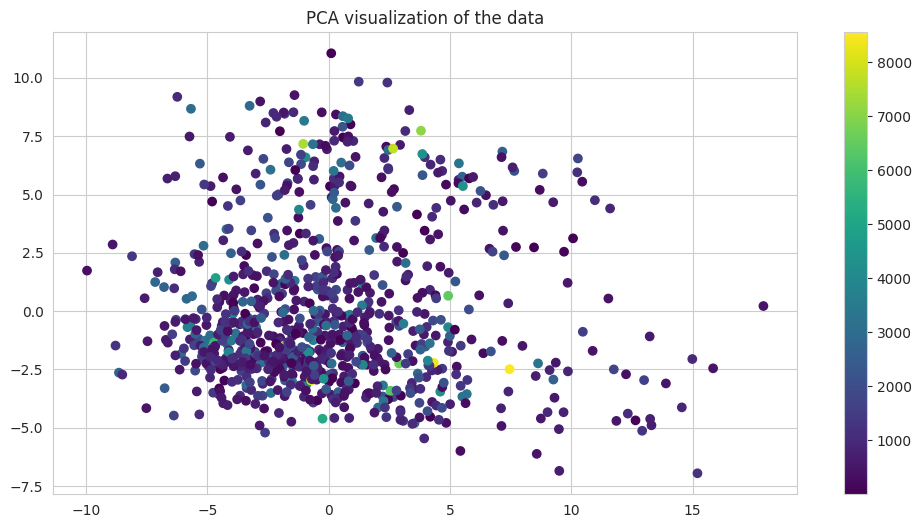

In [ ]:
# Visualize dimension reduction results
plt.figure(figsize=(12, 6))
# component versus survival time
plt.scatter(x_train[:,0], x_train[:,1],c=pd.DataFrame(y_train, columns=['status', 'time']).iloc[:,1], cmap='viridis', marker='o')
plt.colorbar()
plt.title('PCA visualization of the data')
plt.show()

In [ ]:
print(x_train.shape)
print(x_test.shape)

(863, 774)
(216, 774)


In [ ]:
# rank ratio = 0
# As a regression problem: the model learns to directly predict the (log) survival time.
estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=42)

In [ ]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["status"], y["time"], -prediction)
    return result[0]

### Hyperparameter tuning

In [ ]:
param_grid = {"alpha": 2.0 ** np.arange(-12, 13, 2)}

# 5 repetitions of 5-fold cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
gcv = GridSearchCV(estimator, param_grid, scoring=score_survival_model, n_jobs=-1, refit=False, cv=cv)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
gcv = gcv.fit(x_train, y_train)

In [ ]:
print("Best parameters:", gcv.best_params_)
print("Best C-index:", round(gcv.best_score_, 3))

Best parameters: {'alpha': 0.0009765625}
Best C-index: 0.632


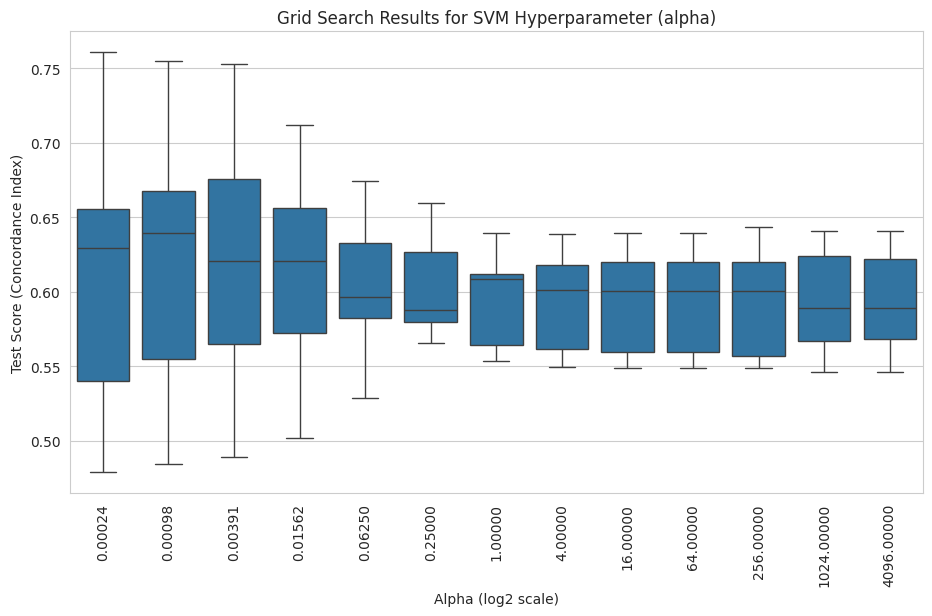

In [ ]:
def plot_performance(gcv):
    cv_results = gcv.cv_results_
    param_values = cv_results['param_alpha'].data.astype(float)
    test_scores = cv_results['mean_test_score']
    n_splits = len(cv_results['split0_test_score'])  # Accessing the number of splits

    cv_scores = {"alpha": [], "test_score": [], "split": []}
    order = []

    for i, param_value in enumerate(param_values):
        name = f'{param_value:.5f}'
        order.append(name)
        for j in range(n_splits):
            vs = cv_results[f"split{j}_test_score"][i]
            cv_scores["alpha"].append(name)
            cv_scores["test_score"].append(vs)
            cv_scores["split"].append(j)

    df = pd.DataFrame.from_dict(cv_scores)
    _, ax = plt.subplots(figsize=(11, 6))
    sns.boxplot(x="alpha", y="test_score", data=df, order=order, ax=ax)
    _, xtext = plt.xticks()
    for t in xtext:
        t.set_rotation("vertical")

    plt.title('Grid Search Results for SVM Hyperparameter (alpha)')
    plt.xlabel('Alpha (log2 scale)')
    plt.ylabel('Test Score (Concordance Index)')
    plt.show()

plot_performance(gcv)

In [ ]:
# Calc x-day RMST prediction error
def calc_pred_error(test_pred, time_point):
    # Compute RMST
    surv_time = pd.DataFrame(test_pred).apply(np.exp).rename(columns={0: 'surv_time'})
    rmst = np.minimum(surv_time, time_point)
    rmst = rmst.rename(columns={'surv_time': 'rmst'})

    # Combine with test data
    test = pd.DataFrame(y_test)
    test['status'] = test['status'].astype(int)
    test = pd.concat([test, rmst], axis=1)

    # Kaplan-Meier estimator of the censoring distribution
    kmf = KaplanMeierFitter()
    kmf.fit(test['time'], 1 - test['status'])
    cen = kmf.survival_function_.reset_index()

    # Calculate prediction error
    up_sum = 0
    low_sum = 0

    for i in range(len(test)):
        if test['time'][i] <= time_point:
            up = (1 / cen[cen['timeline'] == test['time'][i]]['KM_estimate'].iloc[0]) * test["status"][i] * abs(
                test['time'][i] - test['rmst'][i])
            low = (1 / cen[cen['timeline'] == test['time'][i]]['KM_estimate'].iloc[0]) * test["status"][i]
            up_sum += up
            low_sum += low

    pred_error = up_sum / low_sum
    return rmst, pred_error

## 3. Evaluation and Prediction

In [ ]:
# alpha = 0.0009765625

In [ ]:
test_cindex_scores = []
test_prediction_error = []

for _ in range(20):
    estimator.set_params(**gcv.best_params_)
    estimator.fit(x_train, y_train)

    # Evaluate the model on the test set
    # Calculate c-index
    test_pred = estimator.predict(x_test)
    test_cindex = concordance_index_censored(y_test["status"], y_test["time"], -test_pred)
    test_cindex_scores.append(test_cindex[0])

    # Calculate prediction_error for 5-year RMST
    # 5-year: 365.25 * 5 = 1826.25
    time_point = 1826.25
    test_pred_error = calc_pred_error(test_pred, time_point)[1]
    test_prediction_error.append(test_pred_error)

In [ ]:
print("Mean C-index:", round(np.mean(test_cindex_scores),3))
print("Mean prediction:", round(np.mean(test_prediction_error),3))

Mean C-index: 0.611
Mean prediction: 1064.344


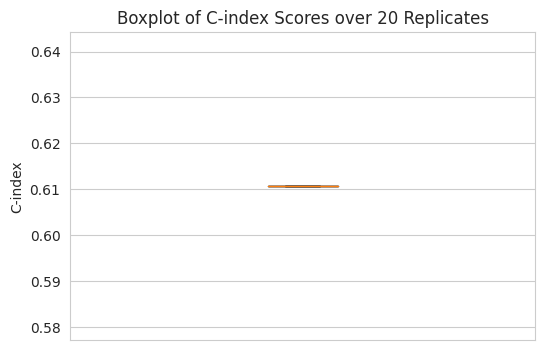

In [ ]:
# Plot boxplot of C-index scores over 20 replicates
plt.figure(figsize=(6, 4))
plt.boxplot(test_cindex_scores)
plt.title('Boxplot of C-index Scores over 20 Replicates')
plt.ylabel('C-index')
plt.xticks([])
plt.show()

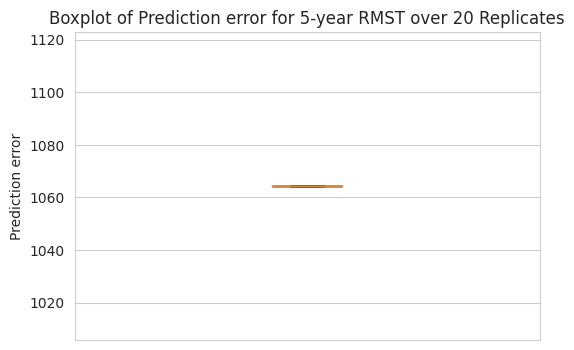

In [ ]:
# Plot boxplot of Prediction error for 5-year RMST scores over 20 replicates
plt.figure(figsize=(6, 4))
plt.boxplot(test_prediction_error)
plt.title('Boxplot of Prediction error for 5-year RMST over 20 Replicates')
plt.ylabel('Prediction error')
plt.xticks([])
plt.show()

In [ ]:
# Combine the lists into one string
combined_data = ''
combined_data += 'c_index_scores:\n'
combined_data += ', '.join(map(str, test_cindex_scores))
combined_data += '\n\nprediction_error:\n'
combined_data += ', '.join(map(str, test_prediction_error))

# Save the combined data to a text file
with open('survival_svm_scores.txt', 'w') as f:
    f.write(combined_data)

# Download the text file
from google.colab import files
files.download('survival_svm_scores.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>